In [ ]:
# ============================================================================
# 🔧 CONFIGURATION - Edit these variables to test different settings
# ============================================================================

# --- Model & Weights ---
KAGGLE_DATASET = "eliplutchok/recod-1219"
KAGGLE_WEIGHTS_FILE = "best_model_clean.pt"
LOCAL_WEIGHTS_PATH = "../checkpoints/best_model.pt"
DINO_PATH = "facebook/dinov2-base"  # or "/kaggle/input/dinov2/pytorch/base/1" on Kaggle
IMG_SIZE = 512
CHANNELS = 4
UNFREEZE_BLOCKS = 3
DECODER_DROPOUT = 0.05

# --- Data ---
DATASET_ID = "eliplutchok/recod-finetune"
SAMPLE_SIZE = None  # None = all

# --- TTA (Test Time Augmentation) ---
USE_TTA = False  # Set to False for faster inference
TTA_HFLIP = True
TTA_VFLIP = True

# --- Post-Processing (re-run evaluation cell after changing these) ---
THRESHOLD = 0.95
MIN_AREA = 100
MIN_MEAN_PROB = 0.35

import os
import kagglehub
WEIGHTS_PATH = os.path.join(kagglehub.dataset_download(KAGGLE_DATASET), KAGGLE_WEIGHTS_FILE)


In [2]:
# Setup, Model Definition & Loading
import os, cv2, math, random
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoModel
from datasets import load_dataset
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class DinoDecoder(nn.Module):
    def __init__(self, in_channels=768, out_channels=4, dropout=0.1):
        super().__init__()
        self.up1 = self._block(in_channels, 384, dropout)
        self.up2 = self._block(384, 192, dropout)
        self.up3 = self._block(192, 96, dropout)
        self.up4 = self._block(96, 48, dropout)
        self.final = nn.Conv2d(48, out_channels, kernel_size=1)
    
    def _block(self, in_ch, out_ch, dropout):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
            nn.Dropout2d(dropout), nn.Conv2d(out_ch, out_ch, 3, padding=1), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True))
    
    def forward(self, features, target_size):
        x = F.interpolate(features, scale_factor=2, mode='bilinear', align_corners=False)
        x = self.up1(x)
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
        x = self.up2(x)
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
        x = self.up3(x)
        x = F.interpolate(x, size=target_size, mode='bilinear', align_corners=False)
        x = self.up4(x)
        return self.final(x)

class DinoSegmenter(nn.Module):
    def __init__(self, backbone, out_channels=4, unfreeze_blocks=3, decoder_dropout=0.1):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(backbone)
        hidden_size = self.encoder.config.hidden_size
        self.register_buffer("mean", torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1))
        self.register_buffer("std", torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1))
        for p in self.encoder.parameters(): p.requires_grad = False
        for i in range(len(self.encoder.encoder.layer) - unfreeze_blocks, len(self.encoder.encoder.layer)):
            for p in self.encoder.encoder.layer[i].parameters(): p.requires_grad = True
        for p in self.encoder.layernorm.parameters(): p.requires_grad = True
        self.decoder = DinoDecoder(hidden_size, out_channels, decoder_dropout)
    
    def forward(self, x):
        x_norm = (x - self.mean) / self.std
        feats = self.encoder(pixel_values=x_norm).last_hidden_state
        B, N, C = feats.shape
        fmap = feats[:, 1:, :].permute(0, 2, 1).reshape(B, C, int(math.sqrt(N-1)), int(math.sqrt(N-1)))
        target_size = (x.shape[2], x.shape[3])
        return self.decoder(fmap, target_size)

print(f"Device: {device}")
print(f"Loading weights from: {WEIGHTS_PATH}")
model = DinoSegmenter(DINO_PATH, CHANNELS, UNFREEZE_BLOCKS, DECODER_DROPOUT).to(device)
ckpt = torch.load(WEIGHTS_PATH, map_location=device, weights_only=False)
model.load_state_dict(ckpt['model_state_dict'] if 'model_state_dict' in ckpt else ckpt)
model.eval()
print("✅ Model loaded")


Device: cuda
Loading weights from: /home/ubuntu/.cache/kagglehub/datasets/eliplutchok/recod-1219/versions/21/best_model_clean.pt


Loading weights: 100%|██████████| 223/223 [00:00<00:00, 1505.24it/s, Materializing param=layernorm.weight]                                 


✅ Model loaded


In [14]:
# Load dataset and cache all model outputs (run once, then test different post-processing)
print(f"Loading dataset: {DATASET_ID}")
dataset = load_dataset(DATASET_ID, split="train")
if SAMPLE_SIZE and SAMPLE_SIZE < len(dataset):
    random.seed(42)
    dataset = dataset.select(random.sample(range(len(dataset)), SAMPLE_SIZE))
print(f"Testing on {len(dataset)} samples")

# Cache: stores (probs, original_size, gt_masks) for each sample
cache = []

@torch.no_grad()
def get_probs(pil_img):
    img = pil_img.resize((IMG_SIZE, IMG_SIZE))
    x = torch.from_numpy(np.array(img, np.float32) / 255.).permute(2, 0, 1)[None].to(device)
    
    if not USE_TTA:
        return torch.sigmoid(model(x))[0].cpu().numpy()
    
    # TTA: accumulate predictions from augmented versions
    preds = [torch.sigmoid(model(x))[0]]
    
    if TTA_HFLIP:
        x_hflip = torch.flip(x, dims=[3])
        pred_hflip = torch.sigmoid(model(x_hflip))[0]
        preds.append(torch.flip(pred_hflip, dims=[2]))  # flip back
    
    if TTA_VFLIP:
        x_vflip = torch.flip(x, dims=[2])
        pred_vflip = torch.sigmoid(model(x_vflip))[0]
        preds.append(torch.flip(pred_vflip, dims=[1]))  # flip back
    
    if TTA_HFLIP and TTA_VFLIP:
        x_both = torch.flip(x, dims=[2, 3])
        pred_both = torch.sigmoid(model(x_both))[0]
        preds.append(torch.flip(pred_both, dims=[1, 2]))  # flip back
    
    return torch.stack(preds).mean(dim=0).cpu().numpy()

tta_desc = f"TTA={'on' if USE_TTA else 'off'}"
if USE_TTA:
    tta_desc += f" (hflip={TTA_HFLIP}, vflip={TTA_VFLIP})"
print(f"Running model on all samples ({tta_desc})...")

for idx in tqdm(range(len(dataset))):
    example = dataset[idx]
    img = example["image"].convert("RGB")
    original_size = img.size
    
    gt_masks = example.get("mask")
    if gt_masks and isinstance(gt_masks, list):
        gt_masks = [np.array(m).astype(np.uint8) for m in gt_masks]
    else:
        gt_masks = []
    
    probs = get_probs(img)
    cache.append({"probs": probs, "size": original_size, "gt": gt_masks})

print(f"✅ Cached {len(cache)} samples. Now you can re-run the evaluation cell with different settings.")


Loading dataset: eliplutchok/recod-finetune
Testing on 5128 samples
Running model on all samples (TTA=on (hflip=True, vflip=True))...


100%|██████████| 5128/5128 [41:30<00:00,  2.06it/s]  

✅ Cached 5128 samples. Now you can re-run the evaluation cell with different settings.


In [15]:
# ⚡ EVALUATE - Re-run this cell after changing post-processing settings in cell 0
import scipy.optimize

def process_probs(probs, size):
    """Apply threshold and filtering to get masks."""
    masks = []
    for ch in range(probs.shape[0]):
        p = probs[ch]
        mask = (p > THRESHOLD).astype(np.uint8)
        mask = cv2.resize(mask, size, interpolation=cv2.INTER_NEAREST)
        if mask.sum() >= MIN_AREA:
            prob_resized = cv2.resize(p, size, interpolation=cv2.INTER_LINEAR)
            if prob_resized[mask == 1].mean() >= MIN_MEAN_PROB:
                masks.append(mask)
    return masks

# Official oF1 metric (from recodai-f1.ipynb)
def calculate_f1_score(pred_mask, gt_mask):
    pred_flat, gt_flat = pred_mask.flatten(), gt_mask.flatten()
    tp = np.sum((pred_flat == 1) & (gt_flat == 1))
    fp = np.sum((pred_flat == 1) & (gt_flat == 0))
    fn = np.sum((pred_flat == 0) & (gt_flat == 1))
    prec = tp / (tp + fp) if (tp + fp) > 0 else 0
    rec = tp / (tp + fn) if (tp + fn) > 0 else 0
    return 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0

def oF1_score(pred_masks, gt_masks):
    """Official optimal F1 with Hungarian matching and excess prediction penalty."""
    if len(gt_masks) == 0 and len(pred_masks) == 0:
        return 1.0  # Both authentic
    if len(gt_masks) == 0 or len(pred_masks) == 0:
        return 0.0  # Mismatch: one authentic, one not
    
    # Build F1 matrix
    f1_matrix = np.zeros((len(pred_masks), len(gt_masks)))
    for i, pm in enumerate(pred_masks):
        for j, gm in enumerate(gt_masks):
            f1_matrix[i, j] = calculate_f1_score(pm, gm)
    
    # Pad if fewer predictions than GT
    if f1_matrix.shape[0] < len(gt_masks):
        f1_matrix = np.vstack((f1_matrix, np.zeros((len(gt_masks) - len(f1_matrix), len(gt_masks)))))
    
    # Hungarian matching
    row_ind, col_ind = scipy.optimize.linear_sum_assignment(-f1_matrix)
    excess_penalty = len(gt_masks) / max(len(pred_masks), len(gt_masks))
    return np.mean(f1_matrix[row_ind, col_ind]) * excess_penalty

results = []
for idx, item in enumerate(cache):
    probs, size, gt_masks = item["probs"], item["size"], item["gt"]
    pred_masks = process_probs(probs, size)
    h, w = size[1], size[0]
    gt_masks_valid = [m for m in gt_masks if m.shape == (h, w)]
    of1 = oF1_score(pred_masks, gt_masks_valid)
    results.append({"idx": idx, "oF1": of1, "n_pred": len(pred_masks), "n_gt": len(gt_masks_valid)})

df = pd.DataFrame(results)

print("=" * 60)
print(f"Threshold={THRESHOLD} | Area≥{MIN_AREA} | Prob≥{MIN_MEAN_PROB}")
print("=" * 60)
print(f"oF1 (official): {df['oF1'].mean():.4f} ± {df['oF1'].std():.4f}")
print(f"Samples with preds: {(df['n_pred'] > 0).sum()}/{len(df)}")


Threshold=0.95 | Area≥100 | Prob≥0.35
oF1 (official): 0.7247 ± 0.3811
Samples with preds: 2214/5128


Worst sample:


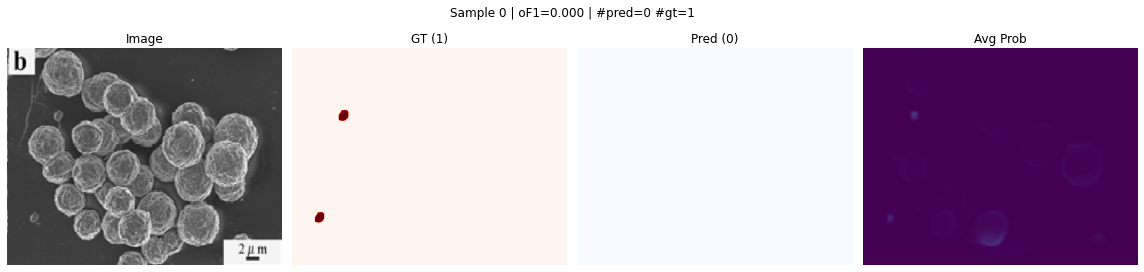

Best sample:


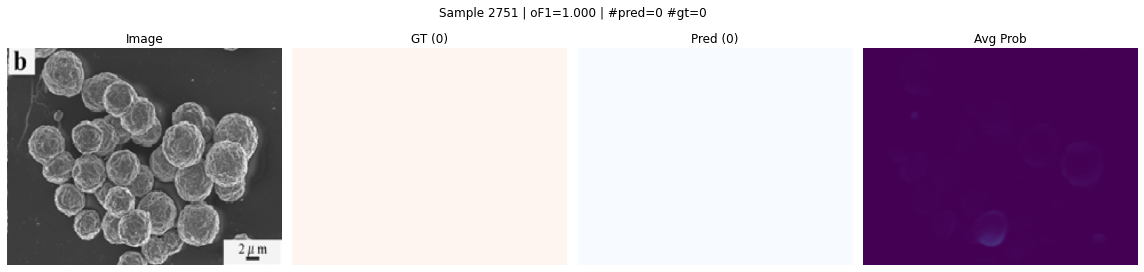

Random sample:


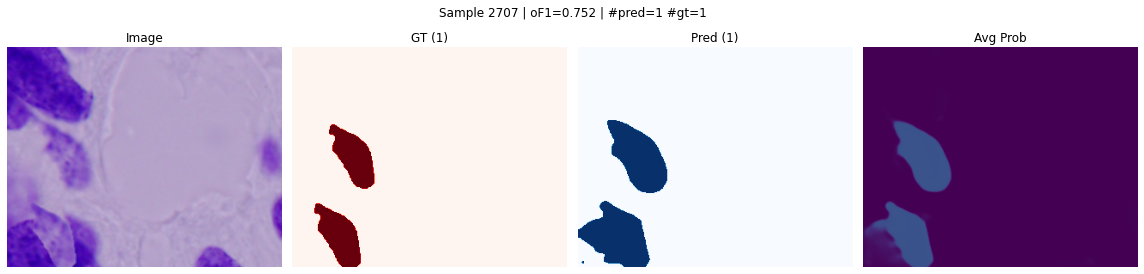

In [5]:
# Visualize samples (worst, random, or specific index)
def viz(idx):
    item = cache[idx]
    probs, size, gt_masks = item["probs"], item["size"], item["gt"]
    pred_masks = process_probs(probs, size)
    img = dataset[idx]["image"].convert("RGB")
    
    h, w = size[1], size[0]
    pred = np.zeros((h, w), dtype=np.uint8)
    for m in pred_masks: pred |= m
    gt_valid = [m for m in gt_masks if m.shape == (h, w)]
    gt = np.zeros((h, w), dtype=np.uint8)
    for m in gt_valid: gt |= m
    
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    axes[0].imshow(img); axes[0].set_title("Image"); axes[0].axis("off")
    axes[1].imshow(gt, cmap="Reds"); axes[1].set_title(f"GT ({len(gt_valid)})"); axes[1].axis("off")
    axes[2].imshow(pred, cmap="Blues"); axes[2].set_title(f"Pred ({len(pred_masks)})"); axes[2].axis("off")
    prob_avg = probs.mean(axis=0)
    axes[3].imshow(cv2.resize(prob_avg, size), cmap="viridis", vmin=0, vmax=1)
    axes[3].set_title("Avg Prob"); axes[3].axis("off")
    
    of1 = oF1_score(pred_masks, gt_valid)
    fig.suptitle(f"Sample {idx} | oF1={of1:.3f} | #pred={len(pred_masks)} #gt={len(gt_valid)}")
    plt.tight_layout(); plt.show()

# Show worst, best, and a random sample
worst_idx = df.loc[df['oF1'].idxmin(), 'idx']
best_idx = df.loc[df['oF1'].idxmax(), 'idx']
print("Worst sample:"); viz(worst_idx)
print("Best sample:"); viz(best_idx)
print("Random sample:"); viz(random.randint(0, len(cache)-1))


In [18]:
# Quick parameter sweep
def eval_with_params(threshold=0.5, min_area=200, min_prob=0.35):
    results = []
    for item in cache:
        probs, size, gt_masks = item["probs"], item["size"], item["gt"]
        masks = []
        for ch in range(probs.shape[0]):
            p = probs[ch]
            mask = (p > threshold).astype(np.uint8)
            mask = cv2.resize(mask, size, interpolation=cv2.INTER_NEAREST)
            if mask.sum() >= min_area:
                prob_r = cv2.resize(p, size, interpolation=cv2.INTER_LINEAR)
                if prob_r[mask == 1].mean() >= min_prob:
                    masks.append(mask)
        h, w = size[1], size[0]
        gt_valid = [m for m in gt_masks if m.shape == (h, w)]
        results.append(oF1_score(masks, gt_valid))
    return np.mean(results)

print("Threshold sweep:")
for t in [0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99]:
    print(f"  threshold={t} → oF1={eval_with_params(threshold=t):.4f}")

Threshold sweep:
  threshold=0.7 → oF1=0.7159
  threshold=0.75 → oF1=0.7203
  threshold=0.8 → oF1=0.7220
  threshold=0.85 → oF1=0.7224
  threshold=0.9 → oF1=0.7236
  threshold=0.95 → oF1=0.7214
  threshold=0.99 → oF1=0.7018


In [ ]:
threshold = .99
min_area = 200

# with tta
# Threshold sweep:
#   threshold=0.7 → oF1=0.7159
#   threshold=0.75 → oF1=0.7203
#   threshold=0.8 → oF1=0.7220
#   threshold=0.85 → oF1=0.7224
#   threshold=0.9 → oF1=0.7236
#   threshold=0.95 → oF1=0.7214
#   threshold=0.99 → oF1=0.7018